# SIR MODEL - NDL
**Network Diffusion Library** https://ndlib.readthedocs.io/en/latest/reference/reference.html

In the code below is shown an example of instantiation and execution of an SIR simulation on a random graph: we set the initial set of infected nodes as 5% of the overall population, a probability of infection of 1%, and a removal probability of 0.5%.


In [1]:
import networkx as nx
import ndlib.models.ModelConfig as mc
import ndlib.models.epidemics as ep

from utils.sdrf import sdrf
from utils import fosr
import utils.data_loader as loader

import numpy as np
import torch
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

import copy
import os
import pickle
import warnings

warnings.filterwarnings("ignore")
%matplotlib inline

In [2]:
def get_cosine(GW):
    from sklearn.metrics.pairwise import cosine_similarity
    from scipy.sparse import coo_matrix

    edge_index = GW.edgelist.detach().cpu()
    n = GW.num_nodes
    adj_sparse = coo_matrix((np.ones(edge_index.shape[1]), (edge_index[0], edge_index[1])),
                        shape=(n, n))

    # Compute cosine similarity using sklearn
    cos_sim = cosine_similarity(adj_sparse)

    return torch.Tensor(cos_sim)

def get_strongest_link2(score, edge_mask, n = None):
    score[torch.logical_not(edge_mask)]=torch.inf
    min = score.min().item()
    argmins = (score == min).nonzero()
    rand_argmin = np.random.choice(argmins.squeeze().shape[0])
    u = argmins[rand_argmin][0]
    v = argmins[rand_argmin][1]
    return u,v
    #n = score.shape[0] if n is None else n
    #u, v = divmod(argmin, n)
    return argmins#, u, v

def get_weakest_link2(score, edge_mask, n = None):
    argmax = (score*edge_mask).argmax().item() #detach and cpu on call
    n = score.shape[0] if n is None else n
    u, v = divmod(argmax, n)
    return u, v

#from standard deviation to 95% CI
import scipy.stats as st
def CI(std, runs, confidence=0.95):
    return 1.96 * (std/np.sqrt(runs))

In [3]:
from utils.GraphWrapper import GraphWrapper
import utils.link_addition_torch as lkadd
from tqdm import tqdm
def add_links(GW, N_LINKS, MODEL):
    if not MODEL in ['fosr', 'sdrf']:
        for i in tqdm(range(N_LINKS)):
            #* Get score
            if MODEL == 'random':
                u, v = lkadd.get_random_link(GW.edge_mask)
            elif MODEL == 'ERP':
                S = GW.get_effective_resistance()

            elif MODEL == 'cosine':
                S = get_cosine(GW)
            else:
                opt_args = {'dim': 128, 'walk_length': 40, 'window_size': 10, 'workers': 4} if MODEL == 'deepwalk' else  {}
                S = lkadd.get_edge_score(GW, MODEL, **opt_args)

            #* Select edge based on score
            if MODEL != 'random':
                if MODEL == 'ERP':
                    u,v = lkadd.get_weakest_link(S.cpu().detach(), GW.edge_mask.cpu().detach(), GW.num_nodes)
                elif MODEL == 'cosine':
                    u,v = get_strongest_link2(S.cpu().detach(), GW.edge_mask.cpu().detach(), GW.num_nodes)
                else:
                    u,v = lkadd.get_strongest_link(S.cpu().detach(), GW.edge_mask.cpu().detach(), GW.num_nodes)
            #print(S.min().item(), S.max().item(), S[u,v].item())
            
            if GW.is_edge(u,v):
                raise Exception('Edge already exists')
            else:
                GW.add_link(u,v)
    else:
        if MODEL == 'sdrf':
            GW, added_links_sdrf = sdrf(copy.deepcopy(GW), loops=N_LINKS, remove_edges=False, removal_bound=2, is_undirected=True, tau=0.9)
            #G_sdrf = G.copy()
            #for e in added_links_sdrf:
            #    G_sdrf.add_edge(e[0],e[1])
        elif MODEL == 'fosr':
            new_edgelist_fosr = fosr.edge_rewire(copy.deepcopy(GW).edgelist.numpy(), num_iterations=N_LINKS, initial_power_iters=100)[0]
            # added_links_fosr to list
            #added_links_fosr = new_edgelist_fosr[:,-N_LINKS*2:].T.tolist()
            #G_fosr = G.copy()
            #for e in added_links_fosr:
            #    G_fosr.add_edge(e[0],e[1])
            GW = GraphWrapper(edgelist=torch.LongTensor(new_edgelist_fosr))
        else:
            raise Exception('Model not supported')

    return GW

**IC MODEL**

In [4]:
#! SIR and IC models

def SIR(G, beta=0.005, lambda_sir=0.00, fraction_infected=0.001, iterations=100):
    """SIR model: susceptible-infected-recovered model

    Args:
        G (_type_): _description_
        beta (float, optional): beta is the infection rate. Defaults to 0.005.
        lambda_sir (float, optional): lambda represents the recovery rate.
        fraction_infected (float, optional): fraction_infected is the fraction of infected nodes at the beginning of the simulation. Defaults to 0.001.
        iterations (int, optional): iterations is the number of iterations the simulation will run. Defaults to 100.

    Returns:
        _type_: _description_
    """

    # Model selection
    #model = ep.SIRModel(G)
    model = ep.SISModel(G)

    # Model Configuration
    cfg = mc.Configuration()
    cfg.add_model_parameter('beta', beta)
    #cfg.add_model_parameter('gamma', 0.00)
    cfg.add_model_parameter('lambda', lambda_sir)
    cfg.add_model_parameter("fraction_infected", fraction_infected)
    model.set_initial_status(cfg)

    # Simulation execution
    history = model.iteration_bunch(iterations)
    return history


def IC_model(G, initial_infected=0.1, threshold=0.2, iterations_IC=100, initial_inf_nodes = None):
    # Model selection
    model = ep.IndependentCascadesModel(G)

    # Model Configuration
    config = mc.Configuration()
    if initial_inf_nodes is None:
        raise Exception('initial_inf_nodes must be specified')
    #config.add_model_parameter('fraction_infected', initial_infected)
    else:
        config.add_model_initial_configuration('Infected', initial_inf_nodes)

    # Setting the edge parameters
    for e in G.edges():
        config.add_edge_configuration("threshold", e, threshold)

    model.set_initial_status(config)

    # Simulation execution
    iterations = model.iteration_bunch(iterations_IC)

    return model, iterations

In [5]:
def load_augmented_graph_IC(dataset_name, num_added_links, device='cuda'):
    GW = loader.load_data(dataset_name, device=device)
    if os.path.exists(f'temp_data/{dataset_name}_NLINKS_{num_added_links}_ERP.pkl'):
        with open(f'temp_data/{dataset_name}_NLINKS_{num_added_links}_ERP.pkl', 'rb') as f:
            GW_erp = pickle.load(f)
        with open(f'temp_data/{dataset_name}_NLINKS_{num_added_links}_COS.pkl', 'rb') as f:
            GW_cos = pickle.load(f)
        with open(f'temp_data/{dataset_name}_NLINKS_{num_added_links}_RAND.pkl', 'rb') as f:
            GW_rand = pickle.load(f)
        with open(f'temp_data/{dataset_name}_NLINKS_{num_added_links}_FOSR.pkl', 'rb') as f:
            GW_fosr = pickle.load(f)
        with open(f'temp_data/{dataset_name}_NLINKS_{num_added_links}_SDRF.pkl', 'rb') as f:
            GW_sdrf = pickle.load(f)
    else:
        if not os.path.exists('temp_data'):
            os.makedirs('temp_data')
        GW_cos = add_links(copy.copy(GW), num_added_links, 'cosine')
        with open(f'temp_data/{dataset_name}_NLINKS_{num_added_links}_COS.pkl', 'wb') as f:
            pickle.dump(GW_cos, f)
        GW_rand = add_links(copy.copy(GW), num_added_links, 'random')
        with open(f'temp_data/{dataset_name}_NLINKS_{num_added_links}_RAND.pkl', 'wb') as f:
            pickle.dump(GW_rand, f)  
        GW_erp = add_links(copy.copy(GW), num_added_links, 'ERP')
        with open(f'temp_data/{dataset_name}_NLINKS_{num_added_links}_ERP.pkl', 'wb') as f:
            pickle.dump(GW_erp, f)
        GW_fosr = add_links(copy.copy(GW), num_added_links, 'fosr')
        with open(f'temp_data/{dataset_name}_NLINKS_{num_added_links}_FOSR.pkl', 'wb') as f:
            pickle.dump(GW_fosr, f)
        GW_sdrf = add_links(copy.copy(GW), num_added_links, 'sdrf')
        with open(f'temp_data/{dataset_name}_NLINKS_{num_added_links}_SDRF.pkl', 'wb') as f:
            pickle.dump(GW_sdrf, f)

    return {'G':GW, 'ERP': GW_erp, 'COS': GW_cos, 'RAND': GW_rand, 'FOSR': GW_fosr, 'SDRF': GW_sdrf}

In [6]:
def get_groups(data): 
    if data == 'google':
        rename_groups = {
            1:'Male',
            0:'Female',
        }
        male=1
        female=0
    else:
        rename_groups = {
            1:'Female',
            0:'Male'
        }
        male=0
        female=1
    return rename_groups, male, female

In [7]:
def to_nx(GWr, node_attribute):
    gg = nx.Graph()
    gg.add_edges_from(GWr.edgelist.T.numpy())
    nx.set_node_attributes(gg, {i:node_attribute[i] for i in range(GWr.num_nodes)}, 'sens')
    return gg

In [8]:
#! functions--> run_IC and process_infected_evolution
def run_IC(G, initial_inf_nodes=None, threshold=None, iterations_IC=None , runs = None):
    iterations_G = []
    if initial_inf_nodes is None:
        raise Exception('initial_inf_nodes must be specified')


    for it in tqdm(range(runs)):
        seed_infected = initial_inf_nodes[it] if initial_inf_nodes.ndim ==2 else [initial_inf_nodes[it]]
        _, iter_G = IC_model(G,
                            initial_inf_nodes=seed_infected , 
                            threshold=threshold, iterations_IC=iterations_IC)
        iterations_G.append(iter_G)
        
    return iterations_G

    #iterations_G.append([iteration['node_count'][1]+iteration['node_count'][2] for iteration in iter_G])
#iterations_G = np.array(iterations_G)

def process_infected_evolution(iterations_G, GW, male, female):
    """
    Processes the infection evolution across runs and iterations.

    Parameters:
    iterations_G: List of dictionaries, where each dictionary contains infection status across multiple iterations.
    GW: A graph or network object that contains node attributes like 'sens'.
    male: The value representing male attribute in 'sens'.
    female: The value representing female attribute in 'sens'.

    Returns:
    infected_evolution: Numpy array of shape (RUNS, IC_ITERS), showing the number of infected nodes at each iteration.
    infection_evolution_male: Numpy array of shape (RUNS, IC_ITERS), showing the number of infected male nodes.
    infection_evolution_female: Numpy array of shape (RUNS, IC_ITERS), showing the number of infected female nodes.
    [DISABLED] infected_nodes_idx: A dictionary mapping each run to a set of infected nodes.
    """

    # Initialize outputs
    infected_nodes_idx = {i: set() for i in range(len(iterations_G))}
    infected_evolution = np.zeros((len(iterations_G), len(iterations_G[0])))
    infection_evolution_male = np.zeros((len(iterations_G), len(iterations_G[0])))
    infection_evolution_female = np.zeros((len(iterations_G), len(iterations_G[0])))

    # Main processing loop
    for i, iterations in enumerate(iterations_G):  # Loop through runs
        for j, exp_iter in enumerate(iterations):  # Loop through iterations in each run
            infected_iter_idx = [node for node in exp_iter['status'] if exp_iter['status'][node] == 1]
            infected_evolution[i][j] = len(infected_iter_idx)
            infected_nodes_idx[i].update(infected_iter_idx)

            # Extracting attributes (male/female) from the infected nodes
            attribute_infected = GW.sens[sorted(infected_nodes_idx[i])].cpu().numpy()
            infection_evolution_male[i][j] = (attribute_infected == male).sum()
            infection_evolution_female[i][j] = (attribute_infected == female).sum()

    return infected_evolution, infection_evolution_male, infection_evolution_female #, infected_nodes_idx


In [9]:
def run_experiment(RUNS, IC_ITERS, THRESHOLD, INITIAL_NODE_SEED, wrappers, wrappers_nx, male, female)->dict:
    results_dict = {}
    np.random.seed(42)
    for G_name in wrappers_nx:
        print(f'Running IC on {G_name}')
        iterations_G = run_IC(wrappers_nx[G_name],
                                initial_inf_nodes=INITIAL_NODE_SEED, threshold=THRESHOLD, iterations_IC = IC_ITERS, runs = RUNS)
        assert RUNS == len(iterations_G)
        assert all(len(run) == IC_ITERS for run in iterations_G), "Mismatch in the number of iterations."

        infection_per_iter, infection_evolution_male, infection_evolution_female = process_infected_evolution(iterations_G, wrappers[G_name], male, female)
        results_dict[G_name] = {'total_infections': infection_per_iter.cumsum(axis=1), 'infection_male': infection_evolution_male, 'infection_female': infection_evolution_female}

    return results_dict

In [10]:
def plot_infection_evolution(infection_evolution_male, infection_evolution_female, ITER_PLOT,
                             attribute_counts, male, female, RUNS, y_lim=None):
    """
    Plots the infection evolution for male and female groups with confidence intervals.

    Parameters:
    infection_evolution_male: Numpy array of male infection evolution.
    infection_evolution_female: Numpy array of female infection evolution.
    ITER_PLOT: The number of iterations to plot.
    attribute_counts: Dictionary with counts of male and female attributes.
    male: The value representing male attribute.
    female: The value representing female attribute.
    RUNS: The number of runs used in the infection evolution data.
    """
    
    def CI(std, runs):
        """Calculate the 95% confidence interval based on standard deviation and number of runs."""
        Z = 1.96  # Z-value for 95% confidence
        return Z * (std / np.sqrt(runs))
    
    f, axs = plt.subplots(1, 3, figsize=(15, 3))

    # Number of infected - Male and Female
    mean_male = infection_evolution_male[:, :ITER_PLOT].mean(axis=0)
    std_male = infection_evolution_male[:, :ITER_PLOT].std(axis=0)
    ci_male = CI(std_male, RUNS)
    axs[0].plot(mean_male, label='Male')
    axs[0].fill_between(range(ITER_PLOT), mean_male + ci_male, mean_male - ci_male, alpha=0.2)

    mean_female = infection_evolution_female[:, :ITER_PLOT].mean(axis=0)
    std_female = infection_evolution_female[:, :ITER_PLOT].std(axis=0)
    ci_female = CI(std_female, RUNS)
    axs[0].plot(mean_female, label='Female')
    axs[0].fill_between(range(ITER_PLOT), mean_female + ci_female, mean_female - ci_female, alpha=0.2)

    axs[0].set_title('# Infected')
    axs[0].legend()

    # Normalized portion of group infected - Male and Female
    mean_male = (infection_evolution_male / attribute_counts[male])[:, :ITER_PLOT].mean(axis=0)
    std_male = (infection_evolution_male / attribute_counts[male])[:, :ITER_PLOT].std(axis=0)
    ci_male = CI(std_male, RUNS)
    axs[1].plot(mean_male, label='Male')
    axs[1].fill_between(range(ITER_PLOT), mean_male + ci_male, mean_male - ci_male, alpha=0.2)

    mean_female = (infection_evolution_female / attribute_counts[female])[:, :ITER_PLOT].mean(axis=0)
    std_female = (infection_evolution_female / attribute_counts[female])[:, :ITER_PLOT].std(axis=0)
    ci_female = CI(std_female, RUNS)
    axs[1].plot(mean_female, label='Female')
    axs[1].fill_between(range(ITER_PLOT), mean_female + ci_female, mean_female - ci_female, alpha=0.2)

    axs[1].set_title('Normalized portion of group infected')
    axs[1].legend()

    # Difference in normalized portion of group infected - Male vs Female
    diffs = np.abs((infection_evolution_male / attribute_counts[male])[:, :ITER_PLOT] - \
            (infection_evolution_female / attribute_counts[female])[:, :ITER_PLOT])
    mean_diff = diffs.mean(axis=0)
    std_diff = diffs.std(axis=0)
    ci_diff = CI(std_diff, RUNS)
    axs[2].plot(mean_diff, label='Disparity')
    axs[2].fill_between(range(ITER_PLOT), mean_diff + ci_diff, mean_diff - ci_diff, alpha=0.2)
    axs[2].set_title('Difference in normalized portion of group infected')
    if y_lim is not None:
        axs[2].set_ylim(y_lim)

    # Show the plot
    plt.tight_layout()
    plt.show()



cmap = plt.get_cmap('tab10')
color_methods = {
    'G': 'black',
    'COS': cmap(0),
    #'cosine_weak': cmap(4),
    #'deepwalk_weak': cmap(5),
    #'deepwalk_strong': cmap(3),
    'RAND': cmap(1),
    'ERP': cmap(2),
    #'ERP_strong': cmap(6),
    'SDRF': cmap(7),
    'FOSR': cmap(8)
}



def plot_method_comparison(results_dict, ITER_PLOT, attribute_counts, male, female, RUNS, var='CI', title = None, relative=None):
    """
    Plots a comparison of different infection methods.

    Parameters:
    results_dict: Dictionary where each key is a method name and value is a dictionary containing
                  'infection_evolution_male' and 'infection_evolution_female' arrays.
    ITER_PLOT: The number of iterations to plot.
    attribute_counts: Dictionary with counts of male and female attributes.
    male: The value representing male attribute.
    female: The value representing female attribute.
    RUNS: The number of runs used in the infection evolution data.
    """
    
    def CI(std, runs):
        """Calculate the 95% confidence interval based on standard deviation and number of runs."""
        Z = 1.96  # Z-value for 95% confidence
        return Z * (std / np.sqrt(runs))

    def plot_line(ax, data, label, color=None, var='CI'):
        mean = data.mean(axis=0)
        std = data.std(axis=0)
        ci = CI(std, RUNS)
        var_data = std if var == 'std' else ci
        ax.plot(mean, label=label, color=color)
        ax.fill_between(range(ITER_PLOT), mean + var_data, mean - var_data, alpha=0.1, color=color)

    # Create a subplot grid
    if relative is None:
        f, axs = plt.subplots(1, 5, figsize=(15, 3))
    elif relative in [True, False]:
        f, axs = plt.subplots(1, 4, figsize=(12, 3))
    else:
        raise ValueError('Invalid value for relative parameter.')

    for method, data in results_dict.items():
        infection_evolution_male = data['infection_male']
        infection_evolution_female = data['infection_female']

        label = 'ERG' if method == 'ERP' else method
 
        # 1. Total infected (male + female)
        total_infected = (infection_evolution_male + infection_evolution_female)[:, :ITER_PLOT]
        plot_line(axs[0], total_infected, label, var=var, color=color_methods[method])
        
        # 2. Proportion of male infected
        male_prop = (infection_evolution_male / attribute_counts[male])[:, :ITER_PLOT]
        plot_line(axs[1], male_prop, label, var=var, color=color_methods[method])
        axs[1].set_ylim(None, 1)

        # 3. Proportion of female infected
        female_prop = (infection_evolution_female / attribute_counts[female])[:, :ITER_PLOT]
        plot_line(axs[2], female_prop, label, var=var, color=color_methods[method])
        axs[2].set_ylim(None, 1)

        if relative is None:
            # 4. Difference in normalized portion of group infected (male - female)
            #diffs = (male_prop - female_prop)/male_prop
            diffs = male_prop - female_prop
            plot_line(axs[3], diffs, label, var=var, color=color_methods[method])
            axs[3].set_title('Infected Diference')
            # Relative difference
            #rel_diffs = np.abs(male_prop - female_prop)/male_prop
            rel_diffs = np.abs(male_prop - female_prop)/np.maximum(female_prop, male_prop) 
            plot_line(axs[4], rel_diffs, label, var=var, color=color_methods[method])
            axs[4].set_title('Relative Difference')
        elif relative is False:
            diffs = male_prop - female_prop
            plot_line(axs[3], diffs, label, var=var, color=color_methods[method])
            axs[3].set_title('Infected Diference')
        elif relative is True:
            rel_diffs = np.abs(male_prop - female_prop)/np.maximum(female_prop, male_prop) 
            plot_line(axs[3], rel_diffs, label, var=var, color=color_methods[method])
            axs[3].set_title('Relative Difference')

    # Set titles and legends for each subplot
    axs[0].set_title('Total Infected')
    axs[0].legend(ncols=1)
    axs[1].set_title('Infected Males')
    axs[2].set_title('Infected Females')
    plt.suptitle(title)
    # Adjust layout for better visualization
    plt.tight_layout()
    plt.show()


facebook
Loaded Graph with 1034 nodes and 26749 edges - L computation mode: exact
temp_data/IC_facebook_IC_RUNS_1000_ITERS_15_TH_0.5_SEED_min_degree.pkl
Results loaded from file


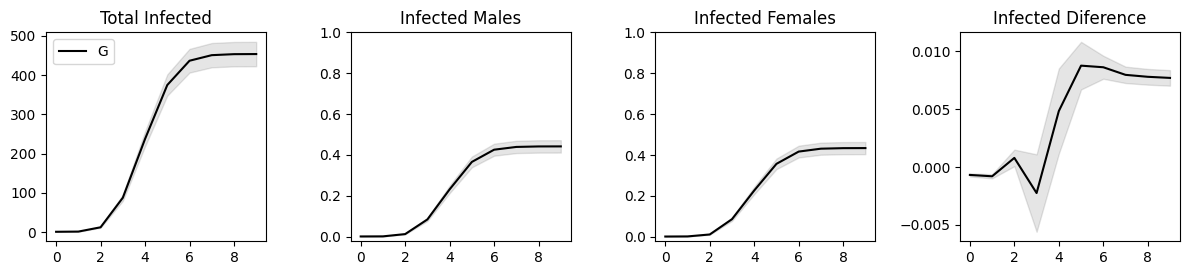

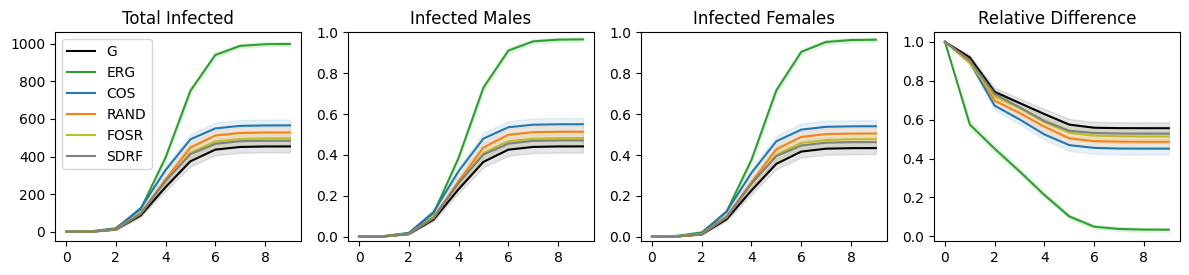

google
Loaded Graph with 3508 nodes and 253930 edges - L computation mode: exact
temp_data/IC_google_IC_RUNS_2000_ITERS_15_TH_0.5_SEED_min_degree.pkl
Results loaded from file


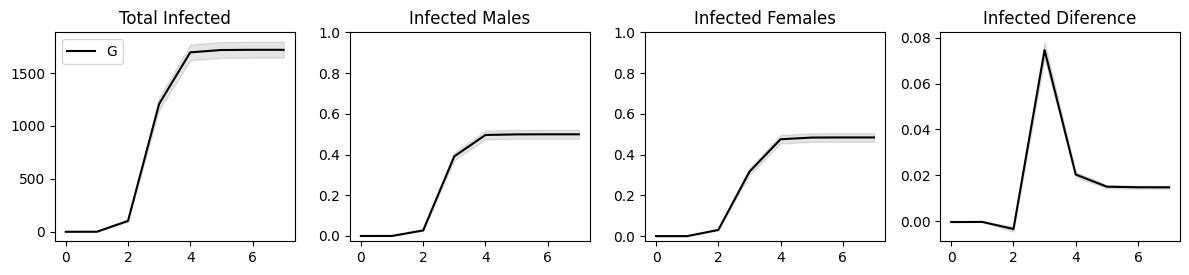

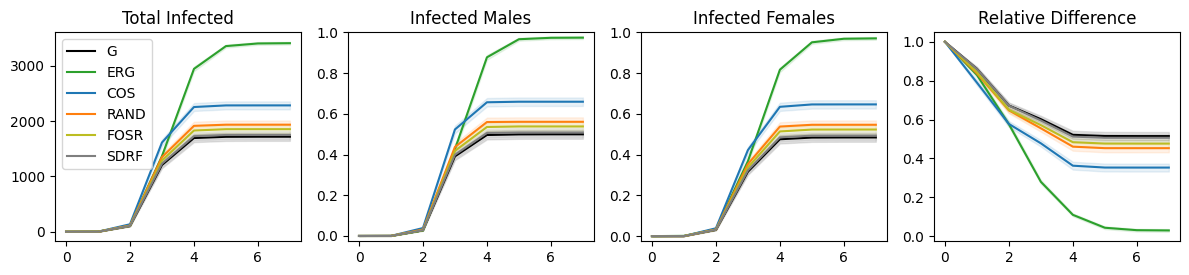

In [11]:
DATASETS = ['facebook', 'google']
INITIAL_NODE_SEED_STRATEGY = ['min_degree', 'random', 'top_min_degree', 'minEST_degree'][0]
IC_ITERS = 15
THRESHOLD = 0.5
save_results = False

DEVICE = 'cuda'
VERBOSE = False

for i, DATASET in enumerate(DATASETS):
    print(DATASET)
    if DATASET == 'google':
        N_LINKS = 500
        RUNS = 2000
        ITER_PLOT = 8
    elif DATASET == 'facebook':
        N_LINKS = 100
        RUNS = 1000
        ITER_PLOT = 10
    else:
        raise Exception('Dataset not supported')
    
    #* Load augmented graphs
    wrappers = load_augmented_graph_IC(DATASET, N_LINKS, device=DEVICE)
    for gg in wrappers:
        if wrappers[gg].sens is None:
            wrappers[gg].sens = torch.Tensor(wrappers['G'].sens)
        
        if VERBOSE:
            print('\t',gg, '|V|', wrappers[gg].num_nodes, '|E|',wrappers[gg].num_edges, end=', ')
            print(f'\t\tR_tot: {wrappers[gg].get_effective_resistance().sum().item():.1f}')
            #**Do nodes get more information from a group or from the other group?**

    # Get sensitive attribute counts
    _, male, female = get_groups(DATASET)
    unique_values, counts = torch.unique(wrappers['G'].sens, return_counts=True)
    attribute_counts = dict(zip(unique_values.tolist(), counts.tolist()))
    if VERBOSE:
        print(attribute_counts, f'Male: {male}, Female: {female}')
        GW = wrappers['G']
        R = GW.get_effective_resistance()
        R_male_cols = R[:, GW.sens==male]
        R_female_cols = R[:, GW.sens==female]
        R_u_from_male = R[:, GW.sens==male].mean(axis=1)
        R_u_from_female = R[:, GW.sens==female].mean(axis=1)
        R_from_male = R_u_from_male.sum()
        R_from_female = R_u_from_female.sum()
        print(R_from_male.item(), R_from_female.item(), (R_from_female - R_from_male).item())



    # Convert to nx
    wrappers_nx = {k:to_nx(wrappers[k], wrappers[k].sens) for k in wrappers}
    if VERBOSE:
            for gg in wrappers_nx:
                print('\t',gg, nx.number_of_nodes(wrappers_nx[gg]), nx.number_of_edges(wrappers_nx[gg]))

    # Get isolated nodes
    G = wrappers_nx['G']
    min_degree_node, min_degree = min(G.degree, key=lambda x: x[1])
    top_min_degree_nodes = [xx[0] for xx in sorted(G.degree, key=lambda x: x[1])[:5]]
    nodes_min_degree = [xx[0] for xx in sorted(G.degree, key=lambda x: x[1]) if xx[1] == min_degree]


    np.random.seed(42)
    if INITIAL_NODE_SEED_STRATEGY == 'min_degree':
        INITIAL_NODE_SEED = np.random.choice(nodes_min_degree, RUNS)
    elif INITIAL_NODE_SEED_STRATEGY == 'minEST_degree':
        INITIAL_NODE_SEED = np.repeat(min_degree_node, RUNS)
    elif INITIAL_NODE_SEED_STRATEGY == 'random':
        INITIAL_NODE_SEED = np.random.choice(G.nodes, RUNS)
    elif INITIAL_NODE_SEED_STRATEGY == 'top_min_degree':
        INITIAL_NODE_SEED = np.repeat(top_min_degree_nodes,RUNS).reshape(len(top_min_degree_nodes),RUNS).T


    exp_res_path = f'temp_data/IC_{DATASET}_IC_RUNS_{RUNS}_ITERS_{IC_ITERS}_TH_{THRESHOLD}_SEED_{INITIAL_NODE_SEED_STRATEGY}.pkl'
    print(exp_res_path)
    if os.path.exists(exp_res_path):
        with open(exp_res_path, 'rb') as f:
            results_dict = pickle.load(f)
        print('Results loaded from file')
    else:
        results_dict = run_experiment(RUNS, IC_ITERS, THRESHOLD, INITIAL_NODE_SEED, wrappers, wrappers_nx, male, female)
        if save_results:
            with open(exp_res_path, 'wb') as f:
                pickle.dump(results_dict, f)

    title = f'Method Comparison ({DATASET} - Links = {N_LINKS}, {THRESHOLD}, {INITIAL_NODE_SEED_STRATEGY})'

    plot_method_comparison({k:results_dict[k] for k in results_dict if k in ['G']}, 
                           ITER_PLOT, attribute_counts, male, female, RUNS, var='CI', title = None, relative=False)
    plot_method_comparison(results_dict, ITER_PLOT, attribute_counts, male, female, RUNS, var='CI', title = None, relative=True)
    